# 06 - Basic Venom - Antivenom Solvers

This file contains basic scripts to solve:
1. Absorbed two-compartment venom dynamics
2. Intravenous two-compartment antivenom dynamics (mass)
3. Intravenous two-compartment antivenom dynamics (concentration)
4. A simulation of envenomation and treatment

The input parameters in step 1 of each script can be modified to change the output dynamics.

The scripts additionally calculate the C<sub>max</sub>, T<sub>max</sub>, Elimination half life ( $T_{1/2}\beta$ ), and Area Under the Curve (AUC<sub>0-t</sub>). AUC is calculated by the composite trapezoidal rule.


## 1. Two-Compartment Venom Dynamics 

This script follows the two-compartment dynamics of a toxin/venom that is absorbed into the central compartment, in this example by intramuscular injection


First, import packages and make 'graphs' output folder if it does not already exist. 

In [26]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

if not os.path.exists('graphs'):
    os.makedirs('graphs')

1. Initialise venom simulation conditions:

In [41]:
#Define simulation parameters
MAXTIME = 25            #hours
START_DOSE = 1*10**6    #1mg -> ng
BIOAVAIL = 0.419        #bioavailability
Tka = 2.2               #absorption rate, h^-1              
Tk10 = 0.0948           #elimination rate, h^-1 
Tk12 = 0.4              #central -> peripheral transfer rate, h^-1
Tk21 = 0.5              #peripheral -> central transfer rate, h^-1
Vc = 1000               #central compartment volume, ml
Vp = 800                #peripheral compartment volume, ml
VENOM = 'N. sumatrana'  #venom or toxin name, for plotting  

Y0 = [START_DOSE*BIOAVAIL, 0, 0] #initial conditions

2. Define intramuscular venom ODE model

In [42]:
#Define compartmental ODE model
def solve_venom(t, Y):
    """This function defines a 2-compartment intramuscular ODE system. The intramuscular compartment is
    solved in units of mass, the central and peripheral compartment in units of concentration.
    Parameters
    ----------
    t: array
        Time
    Y: array
        Initial compartmental conditions array
    Returns
    -------
    dT1dt, dT2dt, dT3dt: array
        Solved results array for intramuscular, central and peripheral compartment (respectively)"""
    T1, T2, T3 = Y
    dT1dt = -Tka*T1   
    dT2dt=  ((Tka*T1)+(Tk21*T3*Vp))/Vc - (Tk10+Tk12)*T2    
    dT3dt= (Tk12*T2*Vc)/Vp - Tk21*T3 
    return dT1dt, dT2dt, dT3dt   

3. Solve ODE model, calculate metrics and plot

In [43]:
#Solve ODE
sol = solve_ivp(solve_venom, (0, MAXTIME), Y0, method='RK45', t_eval=np.linspace(0, MAXTIME, 5000))
#Unpack solutions and timesteps
intramuscular, central, peripheral = sol.y
time=sol.t

#Calculate Cmax, Tmax, Elimination half life, and AUC
beta=0.5*(Tk10+Tk12+Tk21-math.sqrt((Tk10+Tk12+Tk21)**2-(4*Tk10*Tk21))) 
halflife=np.log(2)/beta
Cmax = max(central)
cmax_index = np.where(central == Cmax)
indexpos=cmax_index[0][0]
Tmax=time[indexpos]
AUC=np.trapz(central, x=time)
print('T1/2\u03B2:', f'{halflife:.3}', 'hours') 
print('Cmax:', '{:.0f}'.format(Cmax), 'ng/ml')
print('Tmax:', f'{Tmax:.3}', 'hours' )
print('AUC.0-t:', round(AUC), 'ng/ml.h')

#Plot timecourse
plot1 = plt.figure(1, figsize=(4.5, 3), dpi=1200)
plt.title('%s Venom Simulation' %VENOM, fontsize=10, y=1.05)
plt.plot(time, central, label='Central Compartment', color='black')
plt.plot(time, peripheral, label='Peripheral Compartment', color='black', linestyle='--')
plt.legend(loc='upper right', fontsize=7)
plt.xlabel('Time (hours)', fontsize=8)
plt.ylabel('Venom concentration (ng/ml)', fontsize=8)
plt.xlim([0, MAXTIME])
plt.ylim([0, 350])
plt.xticks(np.arange(0, MAXTIME+1, step=5), fontsize=7)
plt.yticks(fontsize=7)
plt.minorticks_on() 
plt.tight_layout()

#Save and show plot
#plt.savefig('graphs/filename.png', dpi=1200, bbox_inches='tight')
plt.show() 

T1/2β: 13.8 hours
Cmax: 283 ng/ml
Tmax: 0.985 hours
AUC.0-t: 3194 ng/ml.h


## 2. Two-Compartment Antivenom Dynamics Solver (mass)

This script plots the 2-compartment dynamics of a given intravenously injected antivenom scaffold. It follows the mass of the scaffold. The script in section 3 below follows concentration. 

1. Set up antivenom parameter dictionary.

In [44]:
AV_params = {'IgG_k10': 0.0120,
             'IgG_k12': 0.0426,
             'IgG_k21': 0.0989,
             
             'Fab2_k10': 0.0212,
             'Fab2_k12': 0.0613,
             'Fab2_k21': 0.154,
             
             'Fab_k10': 0.0341,
             'Fab_k12': 0.114,
             'Fab_k21': 0.240,
             
             'scfv_k10': 0.0710,
             'scfv_k12': 0.198,
             'scfv_k21': 0.294,
             
             'nb_k10': 0.126,
             'nb_k12': 0.334,
             'nb_k21': 0.327}

1. Initialise simulation conditions

In [45]:
#Define simulation parameters
MAXTIME = 100                      #max runtime, hours
START_DOSE = 1000                  #ng
k10 = AV_params['IgG_k10']         #elimination rate
k12 = AV_params['IgG_k12']         #central -> peripheral transfer rate
k21 = AV_params['IgG_k21']         #peripheral -> central transfer rate
SCAFFOLD = 'IgG'                   #scaffold name for graphs

Y0 = [START_DOSE,0]  #initial conditions

2. Define ODE model 

In [46]:
def mass_av_solver(t, Y):
    """This function defines a 2-compartment intravenous ODE system in units of mass
    Parameters
    ----------
    t: array
        Time
    Y: array
        Initial compartmental conditions array
    Returns
    -------
    dCdt, dPdt: array
        Solved results array for central and peripheral compartment"""
    C, P = Y
    dCdt=  k21*P - (k10+k12)*C 
    dPdt= k12*C - k21*P  
    return dCdt, dPdt

3. Solve ODE model, calculate metrics and plot

IgG Compartmental Simulation Results: 

T1/2β: 85 hours
AUC.0-t: 47536 ng/ml.h
BD: 46.9 % 



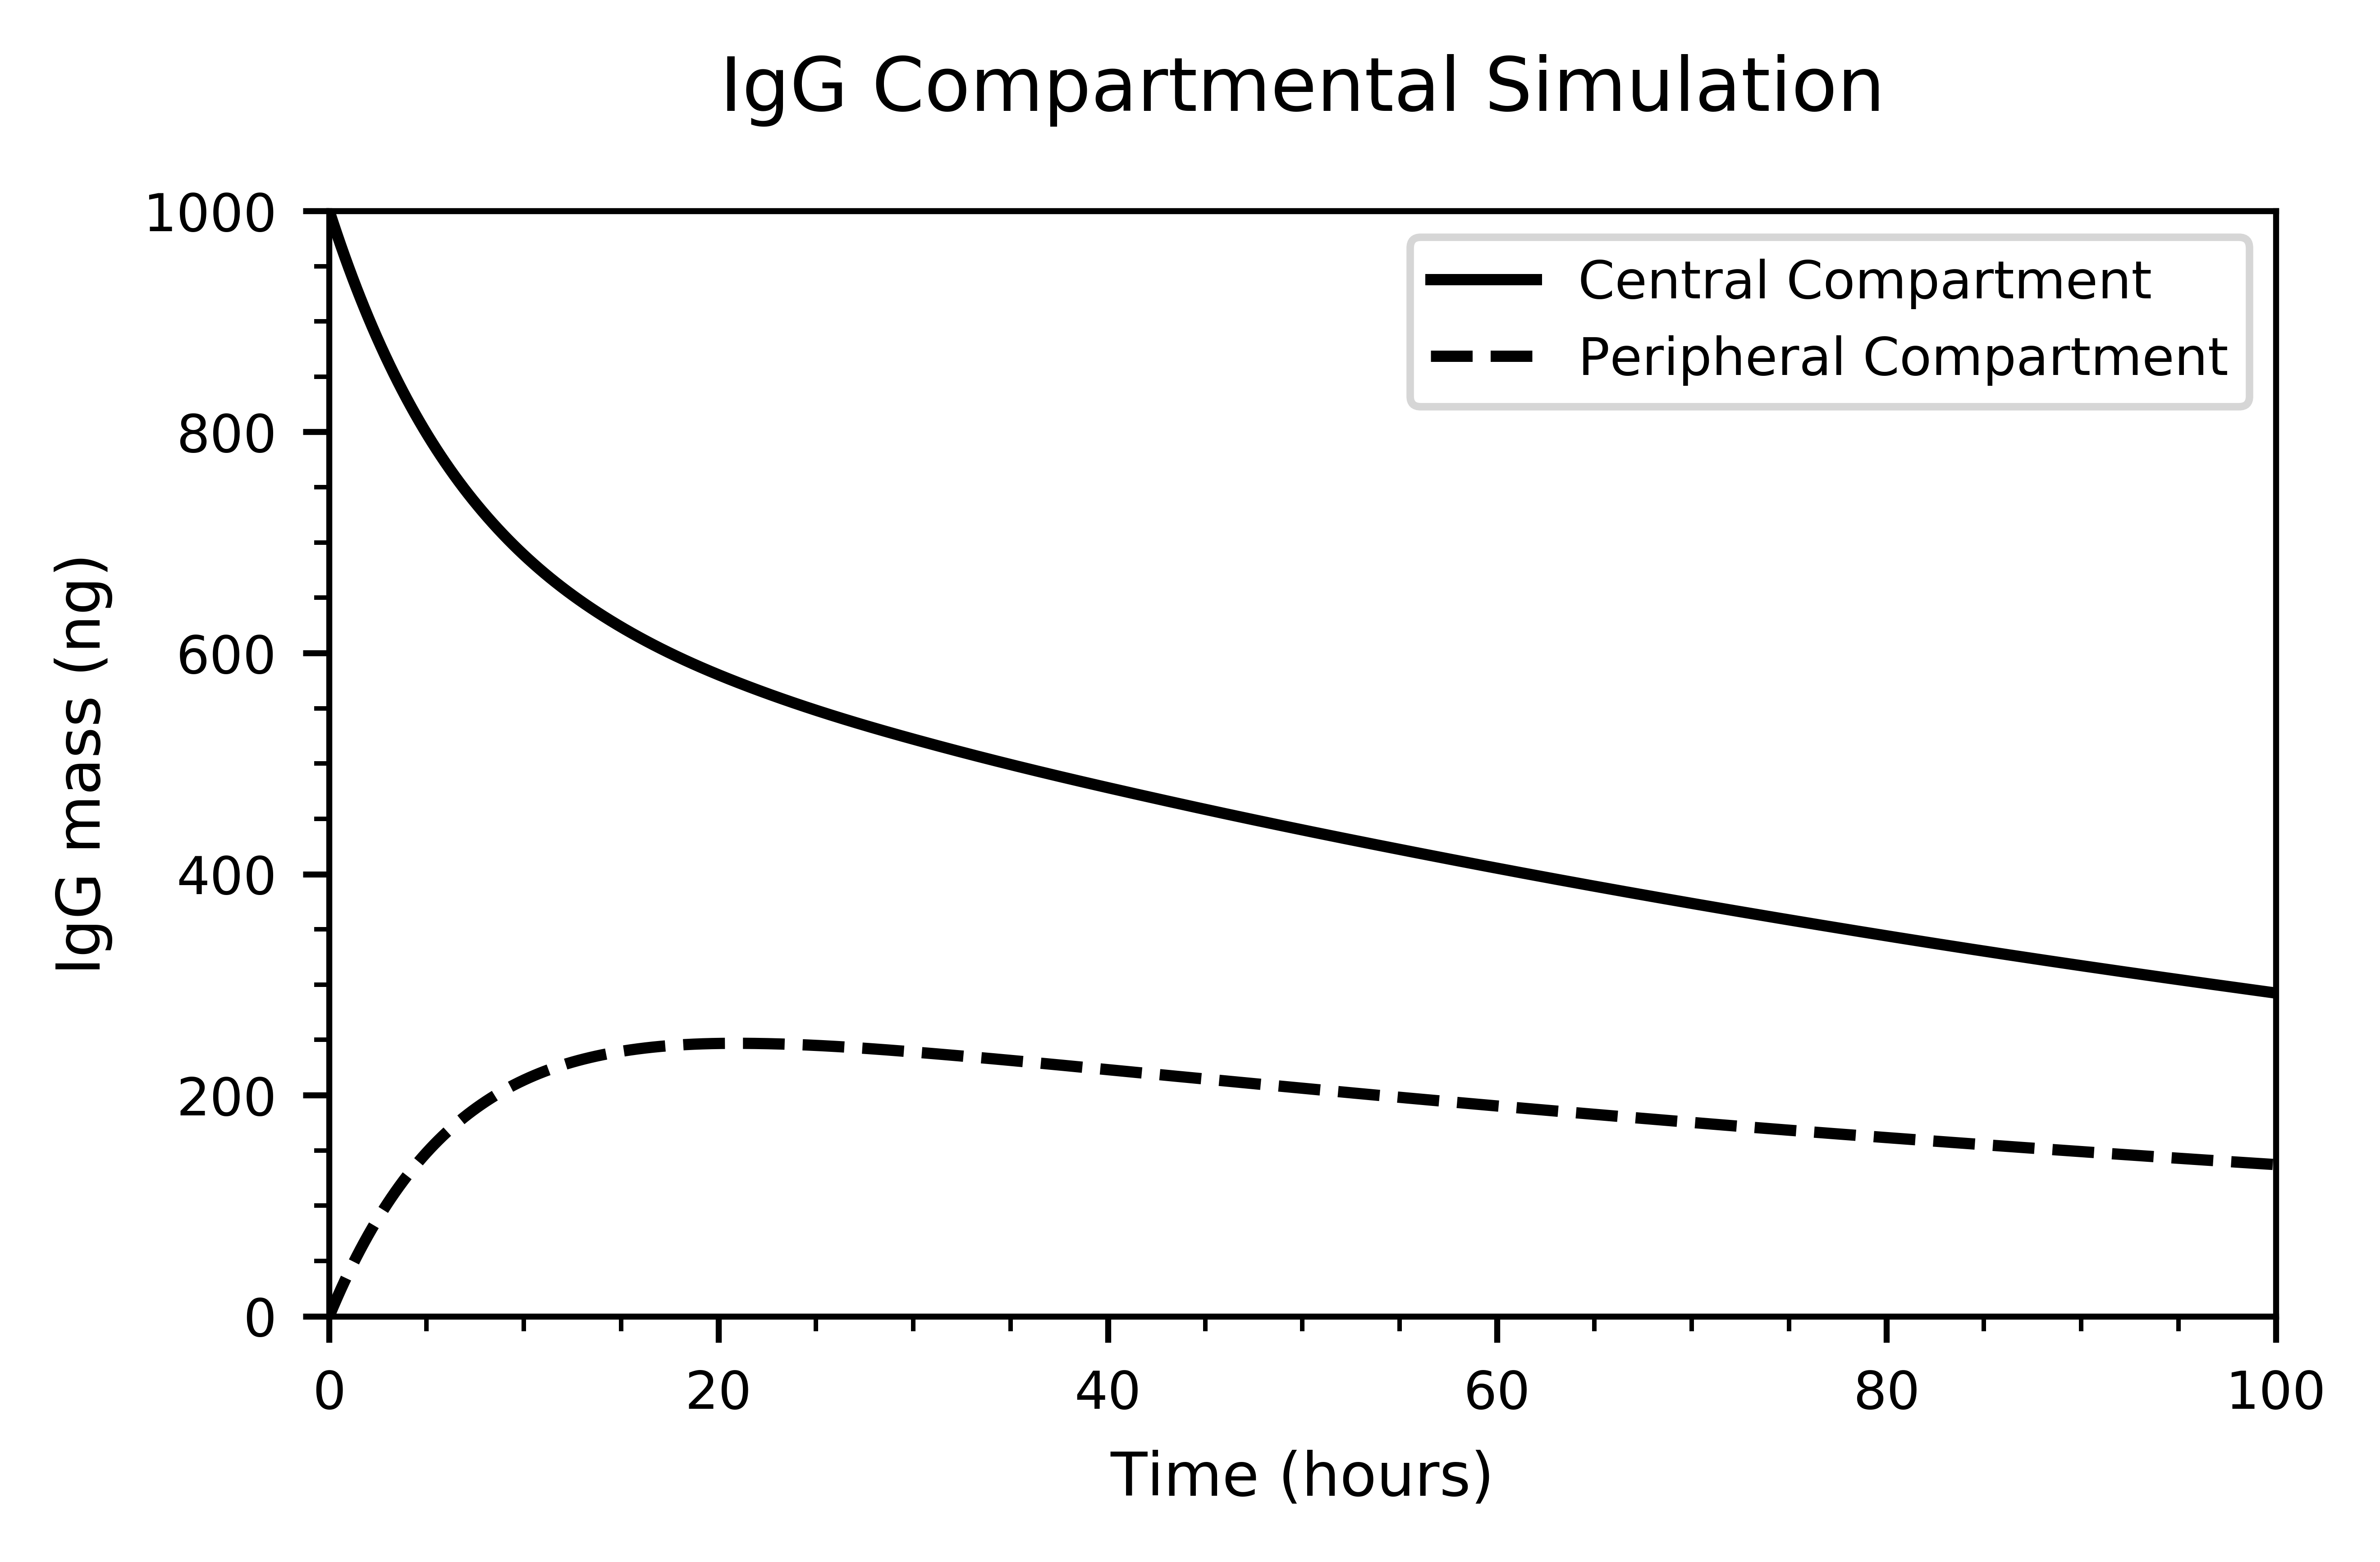

In [47]:
#Solve ODE function
sol = solve_ivp(mass_av_solver, (0, MAXTIME), Y0, method='RK45', t_eval=np.linspace(0, MAXTIME, 5000)) #5000 timestep iterations
#Unpack central and peripheral compartment solutions
central, peripheral = sol.y
#Unpack timesteps
time=sol.t

#Calculate elimination half life, biodistribution, and AUC
beta=0.5*(k10+k12+k21-math.sqrt((k10+k12+k21)**2-(4*k10*k21))) 
halflife=np.log(2)/beta
AUC=np.trapz(central, x=time)
BD=(peripheral[2500]/central[2500])*100 #sampled time must be in elimination phase - sample timepoint 2500 of 5000
print(SCAFFOLD, 'Compartmental Simulation Results:', '\n')
print('T1/2\u03B2:',round(halflife), 'hours') 
print('AUC.0-t:', round(AUC), 'ng/ml.h')
print('BD:', f'{BD:.3}', '%','\n')

#Plot compartmental simulation
plot1 = plt.figure(1, figsize=(4.5, 3), dpi=1200)
plt.title('%s Compartmental Simulation' %SCAFFOLD, fontsize=10, y=1.05)
plt.plot(time, central, label='Central Compartment', color='black')
plt.plot(time, peripheral, label='Peripheral Compartment', color='black', linestyle='--')
plt.legend(loc='upper right', fontsize=7)
plt.xlabel('Time (hours)', fontsize=8)
plt.ylabel('%s mass (ng)' %SCAFFOLD, fontsize=8)
plt.xlim([0, MAXTIME])
plt.ylim([0, START_DOSE])
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.minorticks_on() 
plt.tight_layout()

#Save and show figure
#plt.savefig('graphs/filename.png', dpi=600, bbox_inches='tight')
plt.show() 

## 3. Two-Compartment Antivenom Dynamics Solver (concentration)

This script plots the 2-compartment dynamics of an intravenously injected antivenom scaffold. It follows concentration of the scaffold.

1. Initialise simulation conditions:


In [48]:
MAXTIME = 100                 #max runtime, hours
START_DOSE = 1*10**6          #1mg -> ng    
k10 = AV_params['IgG_k10']         #elimination rate
k12 = AV_params['IgG_k12']         #central -> peripheral transfer rate
k21 = AV_params['IgG_k21']         #peripheral -> central transfer rate
Vc = 1000                     #central compartment vol, ml
Vp = 800                      #peripheral compartment vol, ml
SCAFFOLD = 'IgG'              #scaffold name for graphs

Y0 = [START_DOSE/Vc,0]  #initial conditions

2. Define ODE system

In [50]:
def conc_av_solver(t, Y):
    """This function defines a 2-compartment intravenous ODE system in units of concentration
    Parameters
    ----------
    t: array
        Time
    Y: array
        Initial compartmental conditions array
    Returns
    -------
    dCdt, dPdt: array
        Results array for central and peripheral compartment"""
    C, P = Y
    dCdt=  (k21*P*Vp)/Vc - (k10+k12)*C 
    dPdt= (k12*C*Vc)/Vp - k21*P  
    return dCdt, dPdt

3. Solve ODE system, calculate metrics and plot

IgG Compartmental Simulation Results: 

T1/2β: 85 hours
AUC.0-t: 47536 ng/ml.h
BD: 58.6 % 



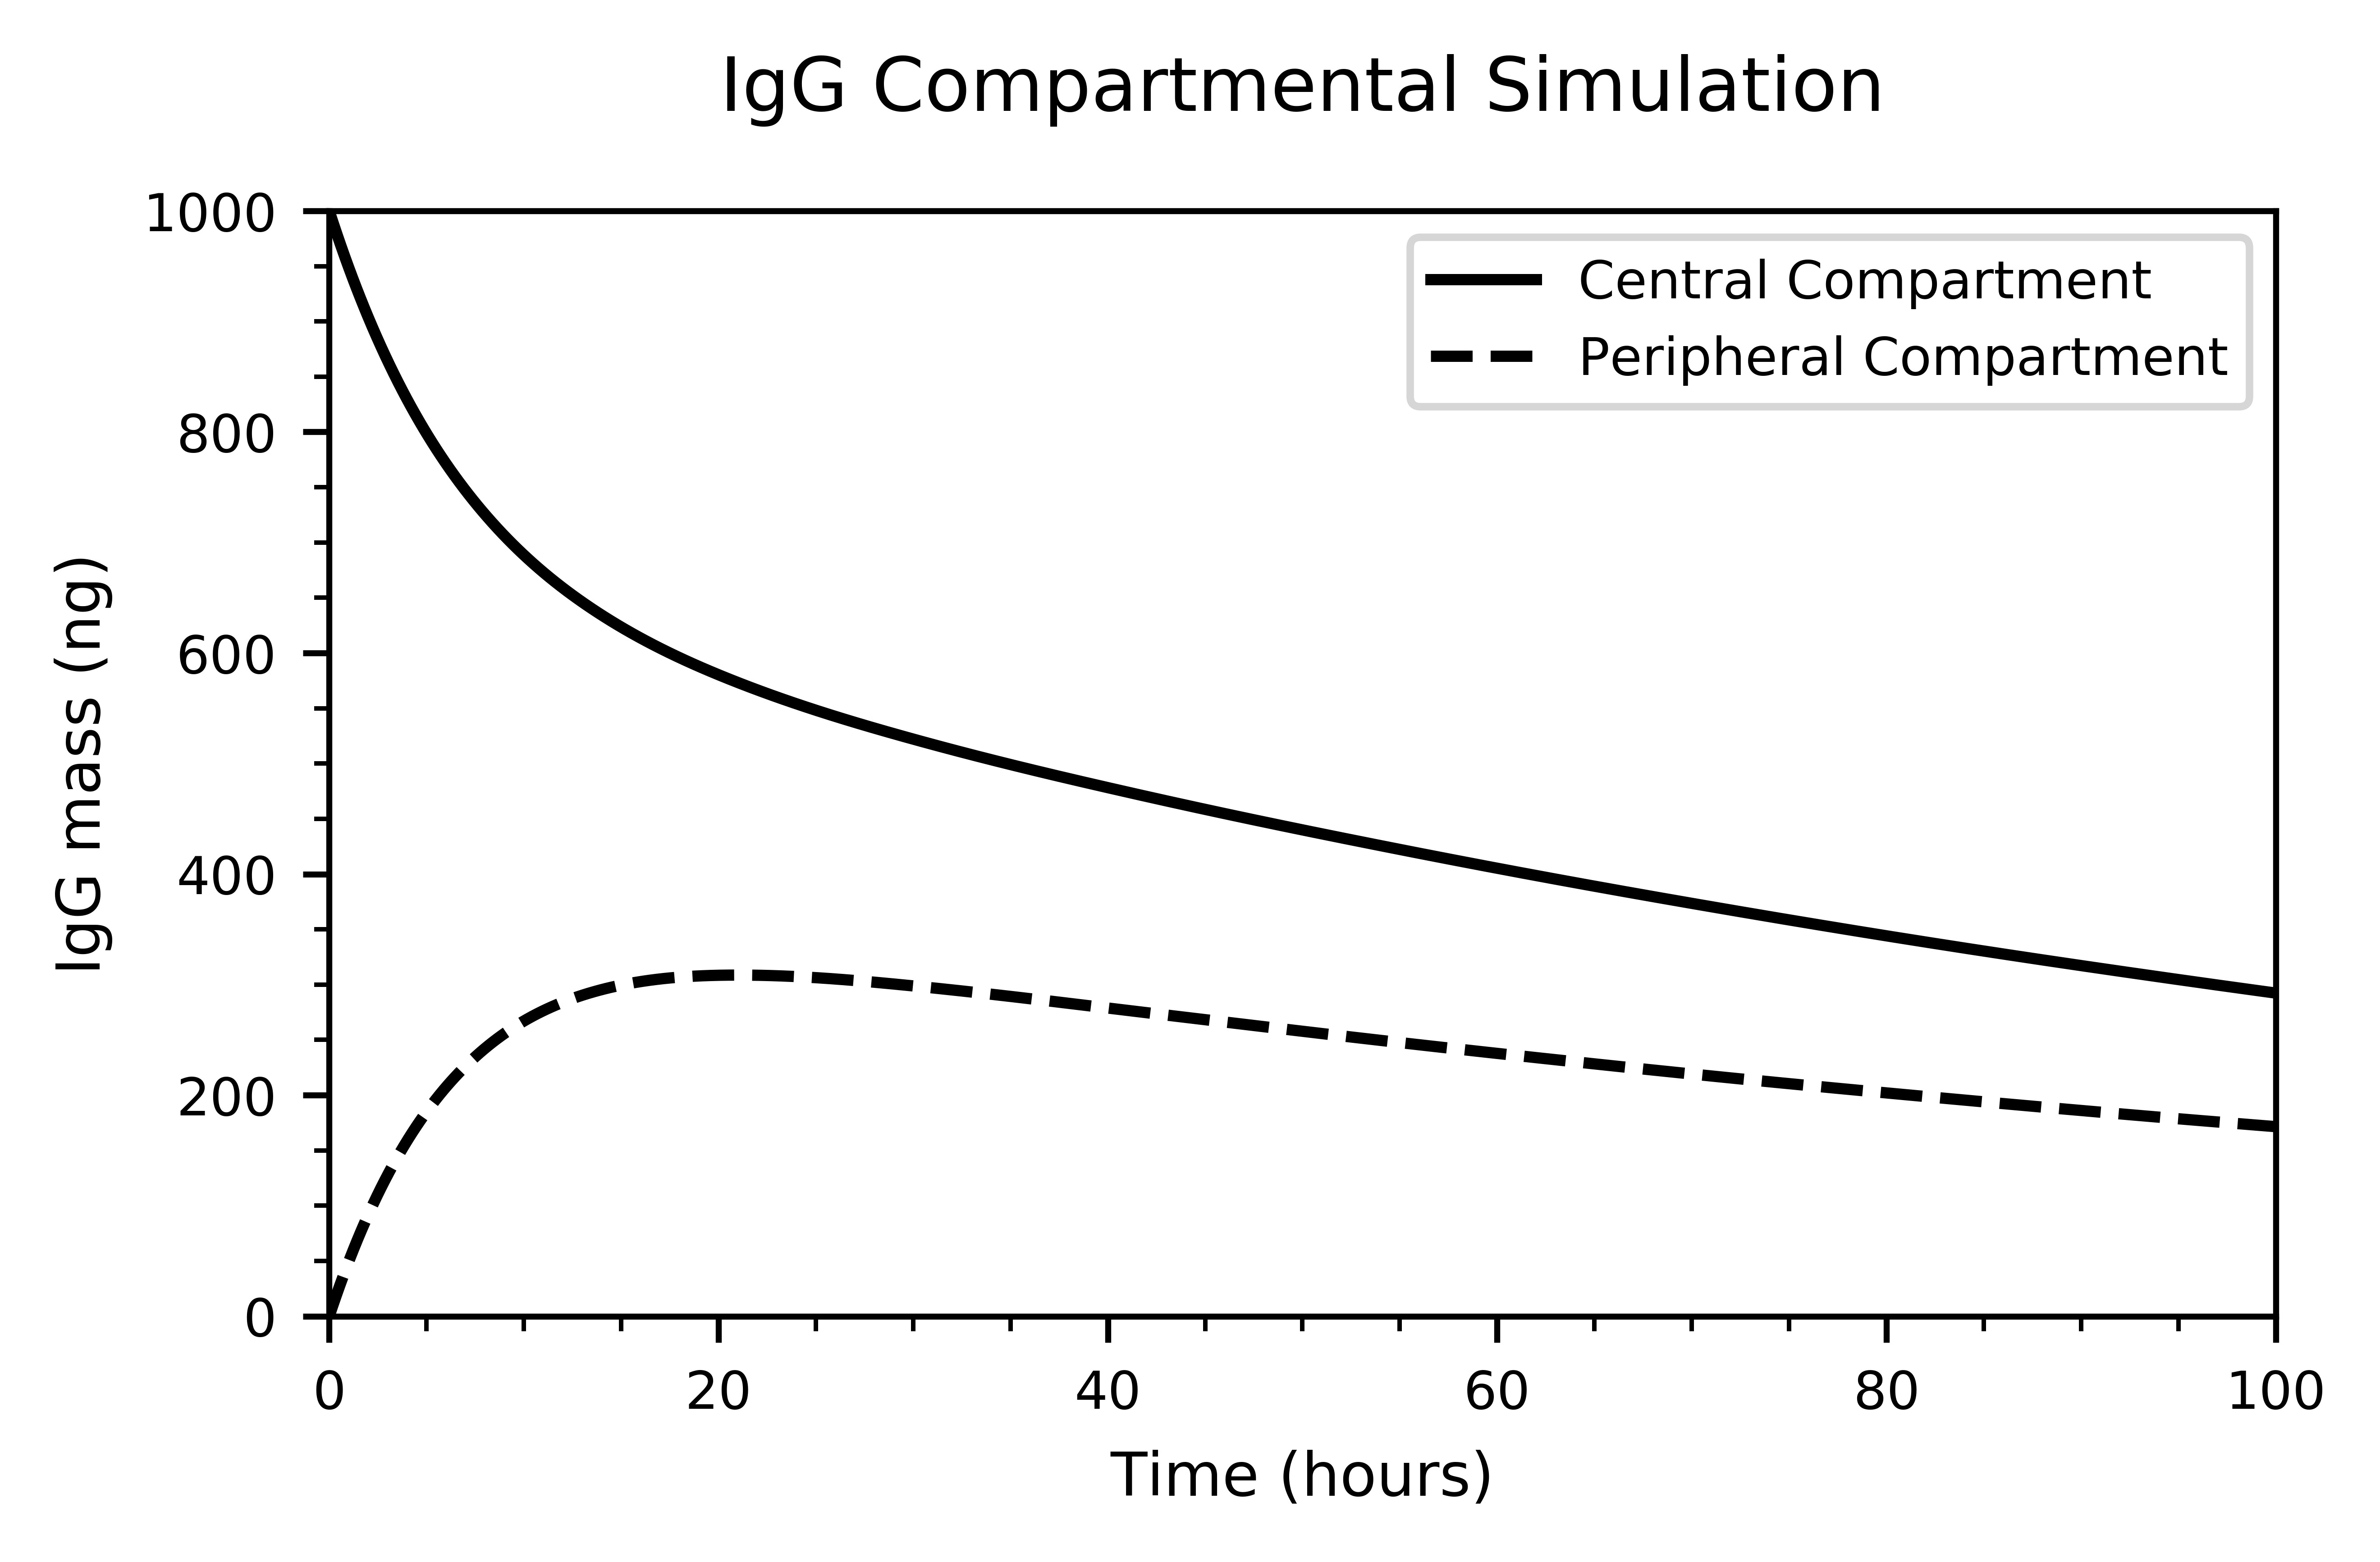

In [51]:
#Solve ODE function
sol = solve_ivp(conc_av_solver, (0, MAXTIME), Y0, method='RK45', t_eval=np.linspace(0, MAXTIME, 5000))
#Unpack central and peripheral compartment solutions
central, peripheral = sol.y
#Unpack timesteps
time=sol.t

#Calculate elimination half life, biodistribution, and AUC
beta=0.5*(k10+k12+k21-math.sqrt((k10+k12+k21)**2-(4*k10*k21))) 
halflife=np.log(2)/beta
AUC=np.trapz(central, x=time)
BD=(peripheral[2500]/central[2500])*100 #sampled time must be in elimination phase - sample timepoint 2500 of 5000
print(SCAFFOLD, 'Compartmental Simulation Results:', '\n')
print('T1/2\u03B2:',round(halflife), 'hours') 
print('AUC.0-t:', round(AUC), 'ng/ml.h')
print('BD:', f'{BD:.3}', '%','\n')

#Plot compartmental simulation
plot1 = plt.figure(1, figsize=(4.5, 3), dpi=1200)
plt.title('%s Compartmental Simulation' %SCAFFOLD, fontsize=10, y=1.05)
plt.plot(time, central, label='Central Compartment', color='black')
plt.plot(time, peripheral, label='Peripheral Compartment', color='black', linestyle='--')
plt.legend(loc='upper right', fontsize=7)
plt.xlabel('Time (hours)', fontsize=8)
plt.ylabel('%s mass (ng)' %SCAFFOLD, fontsize=8)
plt.xlim([0, MAXTIME])
plt.ylim([0, START_DOSE/Vc])
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.minorticks_on() 
plt.tight_layout()

#Save and show figure
#plt.savefig('graphs/filename.png', dpi=600, bbox_inches='tight')
plt.show() 

## 4. Envenomation and Antivenom Treatment Solver

This script solves an envenomation and treatment scenario of your choosing.

1. Initialise simulation conditions

In [52]:
#Set simulation scenario variables
NG = 10**6               #to convert venom/AV dose from mg to ng
DOSETIME = 1             #Time of antivenom administration in hours
MAXTIME = 20             #hours
V_DOSE = 3               #Venom dose (mg)
AV_DOSE = 1              #Antivenom dose (mg)

#Set venom variables
BIOAVAIL = 0.419         #Intramuscular bioavailability
Tka = 2.2                #Venom absorption rate, h^-1         
Tk10 = 0.0948            #Venom elimination rate, h^-1
Tk12 = 0.4               #Venom central > peripheral rate, h^-1
Tk21 = 0.5               #Venom peripheral > central rate, h^-1
Vc = 1000                #Central compartment vol, ml     
Vp = 800                 #Peripheral compartment vol, ml

#Set antivenom variables               
Ak10 = AV_params['Fab_k10']  #AV elim rate, h^-1
Ak12 = AV_params['Fab_k12']  #AV central > peripheral rate, h^-1
Ak21 = AV_params['Fab_k21']  #AV peripheral > central rate, h^-1
AV_mw = 50000           #AV molecular weight (Da)
PRE_KON = 6*10**5        #M^-1.s^-1 -> units are converted inside the function
PRE_KOFF = 1*10**-3      #s^-1 -> units are converted inside the function

 
#Set initial conditions at t=0. Tracking [T1, T2, T3, and E]
Y1 = [V_DOSE*BIOAVAIL*NG, 0, 0, 0]   

#Convert kon/koff units
kon = PRE_KON * 60 * 60 * 1000 * (1/AV_mw) * (1/10**9)  #convert to ml.ng^-1.h^-1    
koff= PRE_KOFF * 60 * 60                                #convert to h^-1

#Set pre and post dose simulation iteration number (3000 total interations)
len1 = int(3000*DOSETIME/MAXTIME)                       #calculates ODE iterations pre-treatment
len2 = int(3000*(MAXTIME-DOSETIME)/MAXTIME)             #calculates ODE iterations post-treatment

2. Define ODE system before and after anitvenom treatment

In [53]:
#Define pre-treatment ODE system
def pre_dose(t, Y):
    """This function defines a 2-compartment intramuscular ODE venom system. The intramuscular venom (T1) is 
    solved in terms of mass. All other species are solved in terms of concentration. 
    Parameters
    ----------
    t: array
        Time
    Y: array
        Initial compartmental conditions array
    Returns
    -------
    dT1dt, dT2dt, dT3dt, dElimdt: array
        Solved results array of intramusuclar (T1), central (T2) and peripheral (T3) compartment venom, 
        and eliminated venom (T4)"""
    T1, T2, T3, elim = Y
    dT1dt = -Tka*T1   
    dT2dt=  ((Tka*T1)+(Tk21*T3*Vp))/Vc - (Tk10+Tk12)*T2    
    dT3dt= (Tk12*T2*Vc)/Vp - Tk21*T3 
    dElimdt = Tk10*T2
    return dT1dt, dT2dt, dT3dt, dElimdt    
      
#Define post-treatment ODE system
def post_dose(t, Y):
    """This function defines a 2-compartment intramuscular venom-antivenom ODE system. The intramuscular venom (T1) is 
    solved in terms of mass. All other species are solved in terms of concentration. 
    Parameters
    ----------
    t: array
        Time
    Y: array
        Initial compartmental conditions array
    Returns
    -------
    dT1dt, dT2dt, dT3dt, dA2dt, dA3dt, dN2dt, dN3dt, dElimdt: array
        Solved results array of venom, antivenom, neutralised venom, and eliminated venom.
        1 corresponds to the intramuscular injection site, 2 to the central compartment, 3 to the peripheral compartment
        T is venom, A is antivenom, N is neutralised venom-antivenom complexes, and Elim is eliminated venom"""
    T1, T2, T3, A2, A3, N2, N3, elim = Y
    dT1dt = -Tka*T1   
    dT2dt=  ((Tka*T1)+(Tk21*T3*Vp))/Vc - T2*(Tk10+Tk12) - (T2*kon*A2) + koff*N2  
    dT3dt= (Tk12*T2*Vc)/Vp - T3*Tk21 - (T3*kon*A3) + koff*N3     
    dA2dt = (Ak21*A3*Vp)/Vc - A2*(Ak12+Ak10) - (A2*kon*T2) + koff*N2
    dA3dt = (Ak12*A2*Vc)/Vp - A3*Ak21 - (A3*kon*T3) + koff*N3  
    dN2dt = kon*(A2*T2) - koff*N2 - Ak10*N2 - Ak12*N2 + (Ak21*N3*Vp)/Vc
    dN3dt = kon*(A3*T3) - koff*N3 - Ak21*N3 + (Ak12*N2*Vc)/Vp
    dElimdt = Tk10*T2 + Ak10*N2 
    return dT1dt, dT2dt, dT3dt, dA2dt, dA3dt, dN2dt, dN3dt, dElimdt

3. Solve ODE systems

In [54]:
#Calculates solution pre AV dose and saves compartmental outputs and timesteps
sol1 = solve_ivp(pre_dose, (0, DOSETIME), Y1, method='RK45',  t_eval=np.linspace(0, DOSETIME , len1))
IMT1, CenT1, PerT1, elim1 = sol1.y
time1=sol1.t    
    
#Generate new initial condition array at time=DOSETIME. Tracking [T1, T2, T3, A2, A3, N2, N3, E]
Y2 = [IMT1[-1], CenT1[-1], PerT1[-1], (AV_DOSE*NG)/Vc, 0, 0, 0, elim1[-1]]

#Calculate the solution after the first dose and extract output values
sol2 = solve_ivp(post_dose, (DOSETIME, MAXTIME), Y2, method='RK45',  t_eval=np.linspace(DOSETIME, MAXTIME, len2))
IMT2, CenT2, PerT2, CenA2, PerA2, CenN2, PerN2, elim2= sol2.y      
time2=sol2.t   
    
#Concatenate pre/post dose results into array
time=np.concatenate([time1, time2])
IMP = np.concatenate([IMT1, IMT2])
CenT = np.concatenate([CenT1, CenT2])
PerT=np.concatenate([PerT1, PerT2])
CenA = np.concatenate([np.zeros(len1), CenA2])
PerA = np.concatenate([np.zeros(len1), PerA2])
CenN = np.concatenate([np.zeros(len1), CenN2])
PerN =  np.concatenate([np.zeros(len1), PerN2])
TotElim = np.concatenate([elim1, elim2])

4. Print metrics and plot graph

In [55]:
#Print Cmax and AUC of venom curve
print('Treating', V_DOSE, 'mg venom at', DOSETIME, 'hours with', AV_DOSE, 'mg antivenom: \n',
      'Central Cmax:', round(max(CenT)), 'ng/ml \n',
      'Central venom AUC.O-t:', round(np.trapz(CenT, x=time)), 'ng/ml.h \n',
      'Peripheral venom AUC.0-t:', round(np.trapz(PerT, x=time)), 'ng/ml.h \n')

#Define the graph area
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 5), dpi=600) 

#Plot central compartment curve
ax1.set_title('Central Compartment', fontsize=10, pad = 8)
ax1.plot(time, CenT, '#d55e00', label='Venom') 
ax1.plot(time, CenA, '#0072b2', label='Antivenom')
ax1.plot(time, CenN, "#009e73", label='Bound Venom')
ax1.plot(time, TotElim, '#cc79a7', label='Eliminated Venom', linestyle='--', zorder=0)
ax1.set_xlabel('Time (hours)', fontsize=8)
ax1.set_ylabel('Concentration (ng/ml)', fontsize=8)
ax1.set_xlim([0, MAXTIME])
ax1.tick_params(axis = 'both', which='major', labelsize = 8)
ax1.minorticks_on()
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',ncol=len(labels), bbox_to_anchor=(0.52, -0.04) , bbox_transform=fig.transFigure, fontsize=8)

#Plot peripheral compartment curve
ax2.set_title('Peripheral Compartment', fontsize=10, pad = 8)
ax2.plot(time, PerT, '#d55e00', label='Venom')
ax2.plot(time, PerA, '#0072b2', label='Antivenom')
ax2.plot(time, PerN, "#009e73", label='Bound Venom')
ax2.set_xlabel('Time (hours)', fontsize=8)
ax2.set_ylabel('Concentration (ng/ml)', fontsize=8)
ax2.set_xlim([0, MAXTIME])
ax2.minorticks_on()

#Set tick label size
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
#Set y axis limits [min, max]
ax1.set_ylim([0, 1000])
ax2.set_ylim([0, 400])
#Set x axis major tick intervals - (min, max, interval)
ax1.xaxis.set_ticks(np.arange(0, MAXTIME+1, 5))
ax2.xaxis.set_ticks(np.arange(0, MAXTIME+1, 5))

#Save and show figure
plt.tight_layout()
#plt.savefig('graphs/graphical_abstract.png', dpi=1000, bbox_inches='tight')
#plt.savefig('graphs/graphical_abstract.eps', dpi=1000, bbox_inches='tight')
plt.show()     
    

Treating 3 mg venom at 1 hours with 1 mg antivenom: 
 Central Cmax: 848 ng/ml 
 Central venom AUC.O-t: 4006 ng/ml.h 
 Peripheral venom AUC.0-t: 3743 ng/ml.h 

